In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-01-08 09:40:46.158427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


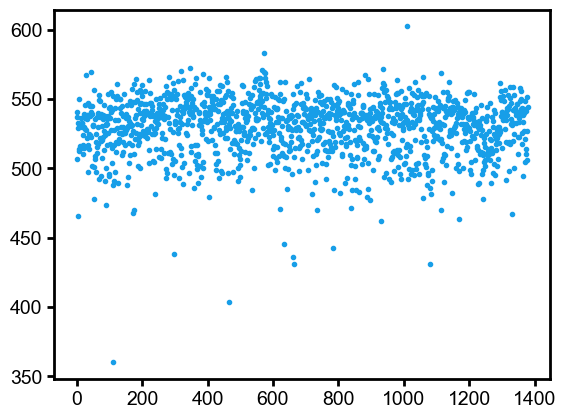

In [3]:
indices = bsccm.get_indices(batch=0)[::100]
images = load_bsccm_images(bsccm, 'LED119', indices=indices)

mean_photons = np.mean(images, axis=(1,2))

#plot mean_photons by image index
fig, ax = plt.subplots()
ax.plot(mean_photons, '.')


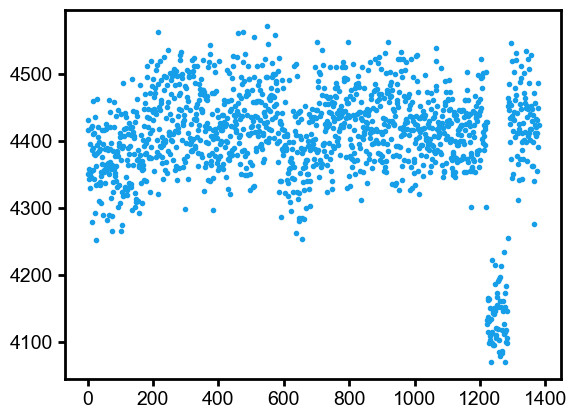

In [4]:
indices = bsccm.get_indices(batch=0)[::100]
images = load_bsccm_images(bsccm, 'Brightfield', indices=indices)

mean_photons = np.mean(images, axis=(1,2))

#plot mean_photons by image index
fig, ax = plt.subplots()
ax.plot(mean_photons, '.')


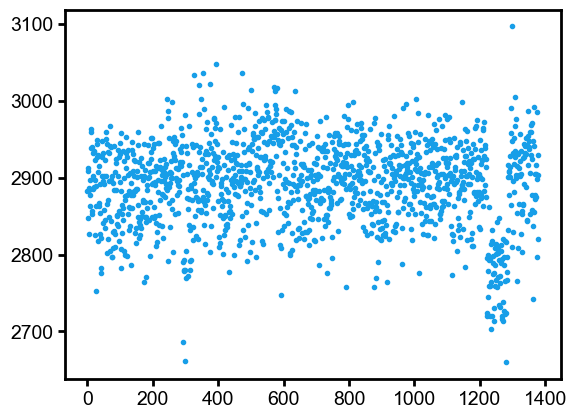

In [5]:
indices = bsccm.get_indices(batch=0)[::100]
images = load_bsccm_images(bsccm, 'DPC_Right', indices=indices)

mean_photons = np.mean(images, axis=(1,2))

#plot mean_photons by image index
fig, ax = plt.subplots()
ax.plot(mean_photons, '.')


In [32]:
bsccm.get_indices(batch=0)[::100][100]

62923

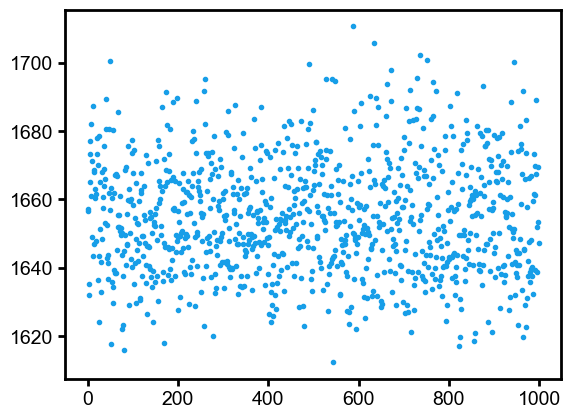

In [11]:
indices = bsccm.get_indices(batch=0)[124000:125000]
images = load_bsccm_images(bsccm, 'Brightfield', indices=indices)

mean_photons = np.mean(images, axis=(1,2))

#plot mean_photons by image index
fig, ax = plt.subplots()
ax.plot(mean_photons, '.')


In [33]:
bsccm.index_dataframe.iloc[360702]
bsccm.index_dataframe.iloc[62923]

position_in_fov_y_pix                                                   1042
position_in_fov_x_pix                                                   1803
detection_radius                                                       20.48
has_matched_histology_cell                                              True
fov_center_x                                                    -33639.91626
fov_center_y                                                     44597.96668
fov_center_z                                                     40908.37109
batch                                                                      0
antibodies                                                         unstained
imaging_date                                                         8/19/18
data_path                     antibodies_unstained/batch_0/slide_replicate_0
slide_replicate                                                            0
Name: 62923, dtype: object

: 

## Reexaminging synthetic noise

In [4]:
indices0 = bsccm.get_indices(batch=0)[:30]
indices1 = bsccm.get_indices(batch=1)[:30]

# get average brightness of LED119 images

images0 = load_bsccm_images(bsccm, 'LED119', indices=indices0)
images1 = load_bsccm_images(bsccm, 'LED119', indices=indices1)

mean_photons0 = np.mean(images0, axis=(1,2))
mean_photons1 = np.mean(images1, axis=(1,2))

print(np.mean(mean_photons0))
print(np.mean(mean_photons1))

208.30275291577817
423.6963586271839


Text(0, 0.5, 'Variance')

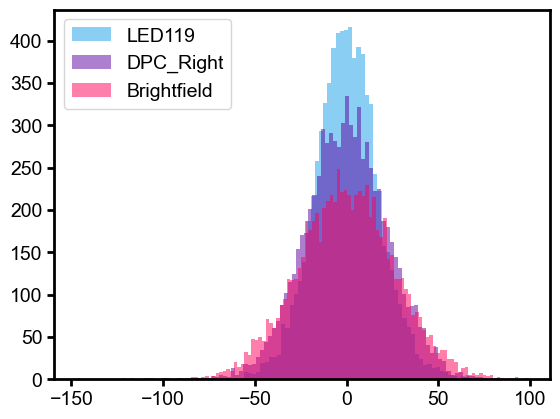

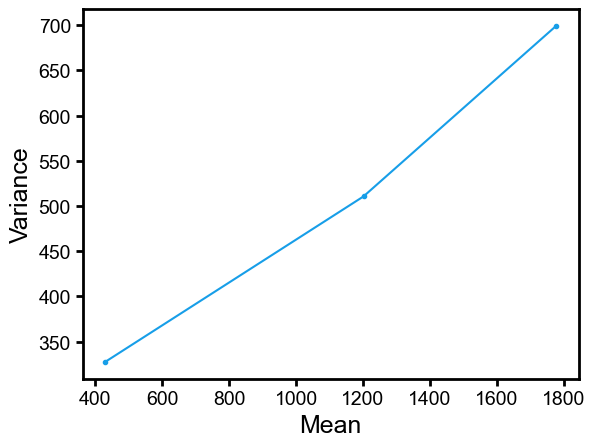

In [31]:
def get_corner_patches(image, mean_sub=True):
    top_left = image[:8, :8]
    top_right = image[:8, -8:]
    bottom_left = image[-8:, :8]
    bottom_right = image[-8:, -8:]
    all = np.stack([top_left.flatten(), top_right.flatten(), bottom_left.flatten(), bottom_right.flatten()])
    # mean subtract
    if mean_sub:
        all = all - np.mean(all, axis=1, keepdims=True)
    return all.ravel()

fig, ax = plt.subplots()
stds = []
means = []
for channel in ['LED119', 'DPC_Right', 'Brightfield']:
    images = load_bsccm_images(bsccm, channel, indices=indices1)
    pixels = np.array([get_corner_patches(image, mean_sub=True) for image in images])
    unnormed_pixels = np.array([get_corner_patches(image, mean_sub=False) for image in images])
    _ = ax.hist(pixels.ravel(), bins=100, alpha=0.5, label=channel)
    stds.append(np.std(pixels))
    means.append(np.mean(unnormed_pixels))
ax.legend()

fig, ax = plt.subplots()
ax.plot(means, np.array(stds) ** 2, '.-')
ax.set_xlabel('Mean')
ax.set_ylabel('Variance')


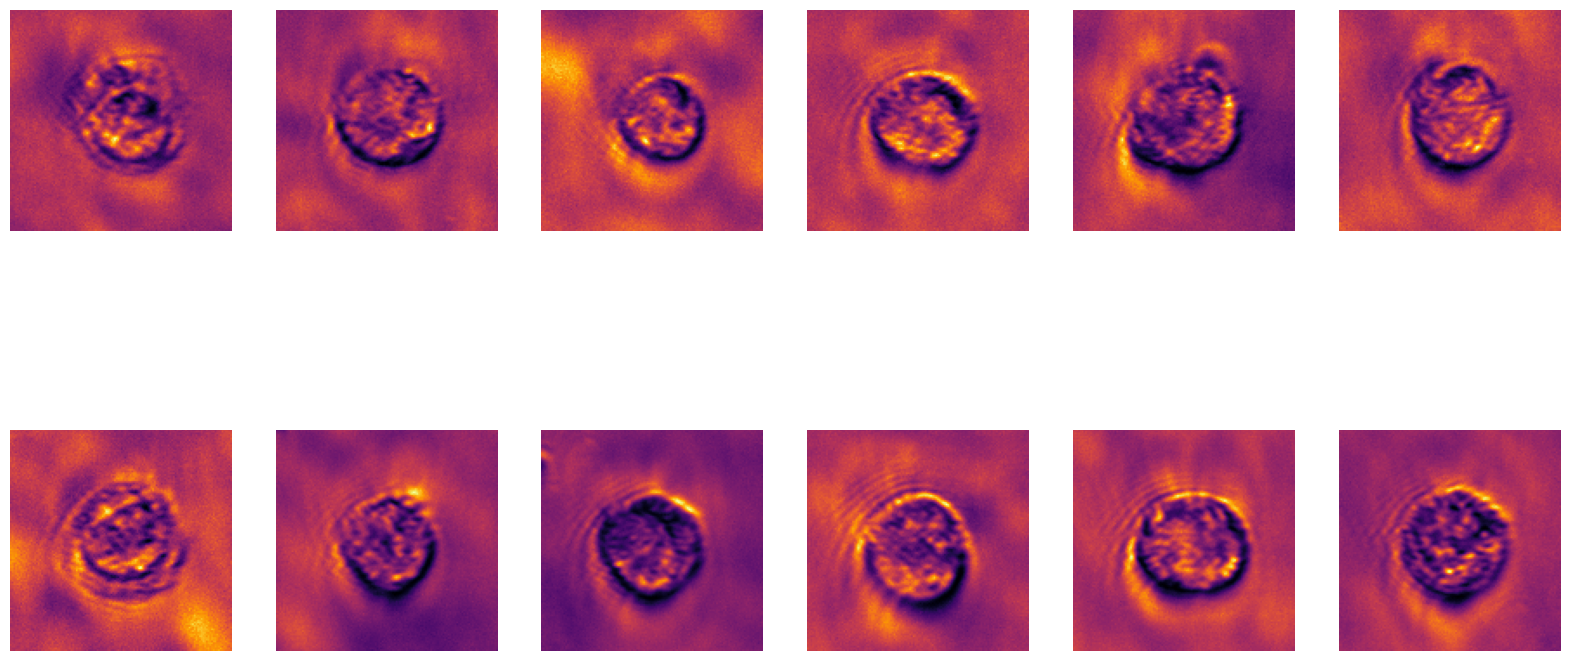

In [21]:

# plot a few images of each
num_to_show = 6

fig, axs = plt.subplots(2, num_to_show, figsize=(20, 10))
for i in range(num_to_show):
    axs[0, i].imshow(images0[i], cmap='inferno')
    axs[0, i].set_axis_off()
    axs[1, i].imshow(images1[i], cmap='inferno')
    axs[1, i].set_axis_off()
